In [24]:
import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
xp_name = 'brouillon'
run_name = "b"
# Iric
iric_path = '/home/ebutz/ESL2024/data/full_iric/iric.csv'
mapped_iric_path  = '/home/ebutz/ESL2024/data/full_iric/altailed_mapped_iric.pickle'
altails_dict_path = '/home/ebutz/ESL2024/data/full_iric/altail_iric_DICT.pickle'
check_dicts = True

ontology_path = '/home/ebutz/ESL2024/data/go-basic.json.gz'

# Set device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Device: '{device}'")

run = wandb.init(project=xp_name, name = run_name)
config = wandb.config
config.val_ratio=0.1
config.homogeneous=False
config.scorelist_size=1000
config.split_ratio=0.8
config.val_ratio=0.1
config.test_ratio=0.1
config.num_neighbors=[70,55,13,89,85]
config.batch_size=1024
config.train_neg_sampling_ratio=224
config.epochs=18
config.disjoint_train_ratio=0.6
config.lr=0.0015308253347932983
config.stopper_metric= 'hit_at_10'
config.stopper_direction="maximize"
config.stopper_patience=5
config.stopper_frequency=1
config.stopper_relative_delta=0.05
config.gamma=1.3
config.alpha=0.42680473078813763
config.gnn_layer='ResGatedGraphConv'
config.dropout=0.1
config.norm='DiffGroupNorm'
config.aggregation = 'min'
config.hidden_channels=115
config.num_layers=3
config.attention_heads=4
config.homogeneous = False
config.labels = {'head' : 'genes', 'relation' : 'gene_ontology', 'tail' : 'go'}

print('Graph is homogeneous :',config.homogeneous)

data = load_iric_data('/home/ebutz/ESL2024/data/full_iric/iric.csv', featureless=False)
GO_edge_index = data['go', 'is_a', 'go'].edge_index
data  = T.ToUndirected(merge=True)(data) # Convert the graph to an undirected graph. Creates reverse edges for each edge.
data = T.RemoveDuplicatedEdges()(data) # Remove duplicated edges
print(data)
print('data look valid : ',data.validate())

train_data, val_data, test_data = split_data(data, config)
train_loader, val_loader, test_loader = build_dataloaders(train_data, val_data, test_data, config)

# # ------------- Loading ontology ------------- #

print("\nLoading ontology...")
nxo = from_file(ontology_path)
nxo.freeze()
pwc.nxo = nxo

df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

# # ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = idx_to_go
pwc.mapped_alt_tails = None
pwc.device           = device

Device: 'cpu'


Graph is homogeneous : False


/home/ebutz/ESL2024/code/utils/train_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links['source_node'] = df_links.index


HeteroData(
  genes={ x=[72335, 29] },
  go={ x=[42979, 3] },
  po={ x=[1662, 2] },
  traito={ x=[1636, 1] },
  prosite_profiles={ x=[627, 1] },
  prosite_patterns={ x=[652, 1] },
  superfamily={ x=[957, 1] },
  panther={ x=[5971, 1] },
  prints={ x=[420, 1] },
  (genes, interacts_with, genes)={ edge_index=[2, 1120849] },
  (genes, gene_ontology, go)={ edge_index=[2, 169248] },
  (genes, trait_ontology, traito)={ edge_index=[2, 15080] },
  (genes, plant_ontology, po)={ edge_index=[2, 6125] },
  (genes, profile, prosite_profiles)={ edge_index=[2, 12239] },
  (genes, pattern, prosite_patterns)={ edge_index=[2, 6677] },
  (genes, family, superfamily)={ edge_index=[2, 20742] },
  (genes, panther_id, panther)={ edge_index=[2, 25319] },
  (genes, prints_id, prints)={ edge_index=[2, 4365] },
  (go, is_a, go)={ edge_index=[2, 136436] },
  (po, is_a, po)={ edge_index=[2, 3548] },
  (traito, is_a, traito)={ edge_index=[2, 3770] },
  (go, rev_gene_ontology, genes)={ edge_index=[2, 169248] },
  (t

In [2]:
idx_to_go[0]

'GO:0048939'

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(src, dist):
    
    G = nx.DiGraph()

    for s, d in zip(src, dist):
        G.add_edge(s, d)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=12, arrows=True)
    plt.title("Graph")
    plt.show()


In [4]:
# import torch

# edge_index = torch.tensor([[0,0,1,2,2,3,3],
#                            [1,2,2,1,4,1,4]])
# src = edge_index[0]
# dist = edge_index[1]
# print(edge_index)

# node_id = 0
# G = nx.DiGraph()
# for s, d in zip(src.tolist(), dist.tolist()):
#     G.add_edge(s, d)

# print('nodes : ',G.nodes)
# for i in G.nodes:
#     print(i)
#     print(list(G.adj[i]))

# plot_graph(src.numpy(), dist.numpy())
# print(f'parents of {node_id} : {get_parents(node_id, edge_index)}')
# print(f'children of {node_id} : {get_children(node_id, edge_index)}')


In [5]:
# GO_edge_index = data['go', 'is_a', 'go'].edge_index

In [46]:
G = nx.DiGraph()
for s, d in zip(GO_edge_index[0].tolist(), GO_edge_index[1].tolist()):
    G.add_edge(s, d)
# Listing terms
all_terms =  torch.cat([GO_edge_index[0], GO_edge_index[1]]).unique().tolist()
print(all_terms)

def plot_graph(edge_index):
    # Création d'un objet graphique NetworkX à partir de edge_index
    G = nx.DiGraph()
    G.add_edges_from(edge_index.t().tolist())

    # Dessiner le graphe
    pos = nx.spring_layout(G)  # Positionnement des nœuds
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    plt.title("Directed Acyclic Graph (DAG)")
    plt.show()

edge_index = torch.tensor([[0, 1, 1, 2, 3, 3, 6],   # Liste des départs des arêtes
                           [1, 2, 3, 3, 4, 5, 5]],  # Liste des arrivées des arêtes
                          dtype=torch.long)
                          *
get

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 22

In [96]:
def nx_successors(graph, node):
    return set([n for n in graph.successors(node)])

def nx_predecessors(graph, node):
    return set([n for n in graph.predecessors(node)])

def nx_neighbors(graph, node):
    return nx_predecessors(graph, node).union(nx_successors(graph, node))

def successors_for_nodes(graph, nodes):
    successors = set()
    for node in nodes:
        successors.update(nx_successors(graph, node))
    return successors

def predecessors_for_nodes(graph, nodes):
    predecessors = set()
    for node in nodes:
        predecessors.update(nx_predecessors(graph, node))
    return predecessors

def neighbors_for_nodes(graph, nodes):
    neighbors = set()
    for node in nodes:
        neighbors.update(nx_neighbors(graph, node))
    return neighbors
'''
G = nx.DiGraph()
for s, d in zip(GO_edge_index[1].tolist(), GO_edge_index[1].tolist()):
    G.add_edge(s, d)
print(G.successors(1))
print([a for a in G.successors(1)])
node = 16164
nodes = {node, 1, 11, 56, 2778}
s = nx_successors(graph=G, node=node)
p = nx_predecessors(graph=G, node=node)
n = nx_neighbors(graph=G, node=node)
print(s,p,n)
ls = successors_for_nodes(graph=G, nodes=nodes)
lp = predecessors_for_nodes(graph=G, nodes=nodes)
ln = neighbors_for_nodes(graph=G, nodes=nodes)
print(ls, lp, ln)
'''

def get_family(ontology_edge_index, max_dist):

    """
    Constructs a family graph up to a certain distance from a given ontology edge index.

    Parameters:
    - ontology_edge_index (torch.Tensor): Edge index tensor representing the ontology graph.
                                          /!\ Graph should be oriented !
    - max_dist (int): Maximum distance to traverse to construct the family graph.      

    Returns:
    - df (pandas.DataFrame): DataFrame containing information about the family graph.
                            Columns:
                                - source : The source node of the row.
                                - 1-neighbors : Set of immediate neighbors of the source node.
                                - 1-children  : Set of immediate children of the source node.
                                - 1-parents   : Set of immediate parents of the source node.
                                - {dist}-neighbors : Set of neighbors at distance 'dist' from the source node.
                                - {dist}-parents   : Set of parents at distance 'dist' from the source node.
                                - {dist}-children  : Set of children at distance 'dist' from the source node.
                                - lineage: Set of all ancestors and descendants up to distance 'max_dist' for the source node.
                                - family_without_lineage: Set of family members excluding lineage for the source node.
    """

    # Init Graph
    G = nx.DiGraph()
    for s, d in zip(ontology_edge_index[0].tolist(), ontology_edge_index[1].tolist()):
        G.add_edge(s, d)

    if not nx.is_directed(G):
        raise Exception("Graph should be directed.")

    # Listing terms
    all_terms =  torch.cat([ontology_edge_index[0], ontology_edge_index[1]]).unique().tolist()
    # print(all_terms)
    df = pd.DataFrame(all_terms, columns=['source'])
    df['source']      = df.apply(lambda row : set([int(row['source'])]), axis = 1)
    df['1-neighbors'] = df.apply(lambda row :    neighbors_for_nodes(graph = G, nodes = row['source']), axis=1)
    df['1-children']  = df.apply(lambda row :   successors_for_nodes(graph = G, nodes = row['source']), axis=1)
    df['1-parents']   = df.apply(lambda row : predecessors_for_nodes(graph = G, nodes = row['source']), axis=1)

    for dist in range(2, max_dist+1):

        step = f'Distance {dist}/{max_dist}'
        print(step)

        tqdm.pandas(desc=f'Making dist {dist}-neighbors ')
        df[f'{dist}-neighbors'] = df.progress_apply(lambda row : neighbors_for_nodes(graph = G, nodes = row[f'{dist-1}-neighbors'])-set.union(*[row[f'{d}-neighbors'] for d in range(1,dist)]),axis = 1)

        tqdm.pandas(desc=f'Making dist {dist}-parents   ')
        df[f'{dist}-parents'] = df.progress_apply(lambda row : predecessors_for_nodes(graph = G, nodes = row[f'{dist-1}-parents']),axis = 1)

        tqdm.pandas(desc=f'Making dist {dist}-children  ')
        df[f'{dist}-children'] = df.progress_apply(lambda row : successors_for_nodes(graph = G, nodes = row[f'{dist-1}-children']),axis = 1)
        
        # display(df)
    
    step = f'{dist}-family acquired.'
    print(step)

    tqdm.pandas(desc=f'Calculating lineage          ')
    df['lineage'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-children'] for dist in range(1, max_dist+1)]+
                                                             [row[f'{dist}-parents'] for dist in range(1, max_dist+1)] +
                                                             [row['source']]),axis=1)
    
    tqdm.pandas(desc=f'Calculating family - lineage ')
    df['family_without_lineage'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-neighbors'] for dist in range(1, max_dist+1)]) - row['lineage'],axis=1)
    # display(df)
    # Re-ordering columns :
    dists = range(1, max_dist+1)
    df = df[['source'] + [f'{dist}-neighbors' for dist in dists] + [f'{dist}-children' for dist in dists] + [f'{dist}-parents' for dist in dists]  + ['lineage', 'family_without_lineage']]

    return df

# df = get_family(ontology_edge_index = GO_edge_index,max_dist = 1)
# display(df)

df3 = get_family(GO_edge_index, max_dist = 3)
display(df3)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 22

Making dist 2-children  : 100%|██████████| 42769/42769 [00:00<00:00, 117973.14it/s]


Distance 3/3


Making dist 3-children  : 100%|██████████| 42769/42769 [00:00<00:00, 112201.08it/s]


3-family acquired.


Calculating family - lineage : 100%|██████████| 42769/42769 [00:01<00:00, 23507.49it/s]


,source,1-neighbors,2-neighbors,3-neighbors,1-children,2-children,3-children,1-parents,2-parents,3-parents,lineage,family_without_lineage
0,{0},{40582},"{0, 42913, 11042}","{31238, 5288, 40713, 7627, 19570, 6291, 42004}",{40582},{42913},{6291},{},{},{},"{0, 42913, 6291, 40582}","{11042, 31238, 5288, 40713, 7627, 19570, 42004}"
1,{1},{26909},"{1, 40578, 28243, 2830}","{38084, 11845, 9706, 39755, 42326, 30269}",{26909},"{40578, 2830}","{9706, 38084}",{},{},{},"{1, 40578, 38084, 9706, 26909, 2830}","{11845, 39755, 28243, 42326, 30269}"
2,{2},"{29032, 29802, 22252, 39762}","{38656, 2, 36098, 32003, 7686, 6920, 26380, 22...","{26630, 8224, 4132, 36916, 38965, 8247, 6203, ...","{29032, 29802, 22252, 39762}","{8696, 10582, 3991, 20472, 34411, 3836, 28367}","{8897, 5353, 20959, 33677, 28367, 8696, 37662,...",{},{},{},"{8897, 2, 33677, 28367, 39762, 10582, 3991, 37...","{26630, 22541, 26651, 30750, 8224, 4132, 38964..."
3,{3},"{37048, 12074}","{25728, 21249, 3, 36039, 38411, 38796, 23693, ...","{13826, 38924, 42511, 21520, 38934, 34839, 153...","{37048, 12074}","{21249, 40892, 40429}","{23505, 29044, 12965}",{},{},{},"{21249, 3, 12965, 12074, 40429, 23505, 29044, ...","{13826, 38411, 38924, 42511, 21520, 38934, 348..."
4,{4},"{136, 14881, 14581, 9485}","{7423, 4, 11482, 9163, 10636, 11597, 13934, 38...","{3968, 4480, 20608, 31753, 29437, 28940, 23319...","{9485, 14581}","{30459, 10636}","{20608, 31753}","{136, 14881}",{},{},"{20608, 14881, 4, 136, 31753, 10636, 9485, 145...","{3968, 4480, 28940, 23319, 4385, 11426, 18212,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42764,{42974},"{14499, 41076, 24166}","{38912, 34240, 26309, 6534, 26439, 11397, 1498...","{4096, 11271, 5640, 19468, 40972, 13331, 18459...","{14499, 41076, 24166}","{42448, 14435, 11397, 31606, 18717}","{14435, 31606, 25308, 12893, 31438}",{},{},{},"{14499, 14435, 11397, 24166, 12893, 31438, 424...","{38912, 4096, 11271, 5640, 19468, 40972, 13838..."
42765,{42975},"{1548, 2246}","{4192, 24739, 3620, 17963, 27372, 23021, 26925...","{130, 19206, 13196, 42127, 33935, 41747, 33943...","{1548, 2246}","{27372, 13310}","{25881, 13196}",{},{},{},"{27372, 2246, 25881, 13196, 1548, 13310, 42975}","{130, 19206, 42127, 33935, 41747, 33943, 37916..."
42766,{42976},{30014},"{3651, 24836, 30853, 8965, 20935, 38599, 37833...","{25095, 28167, 18439, 15888, 6162, 31252, 3125...",{30014},{12323},{37778},{},{},{},"{42976, 37778, 12323, 30014}","{25095, 28167, 18439, 15888, 6162, 31252, 3125..."
42767,{42977},"{29375, 40054, 14567}","{36635, 42977, 13507, 22141, 12411, 35757, 257...","{30851, 27653, 30469, 25609, 3599, 42645, 1846...",{40054},"{36635, 16605}","{30851, 11459}","{29375, 14567}",{},{},"{42977, 30851, 11459, 40054, 14567, 36635, 166...","{27653, 30469, 25609, 25742, 3599, 42645, 1846..."


GO:0048939
GO:0007313
GO:1901940
GO:1903864


In [79]:
G = nx.DiGraph()
G.add_edges_from(edge_index.t().tolist())
G

In [98]:
s = get_family(edge_index, max_dist = 4)

[0, 1, 2, 3, 4, 5, 6]
Distance 2/4


Making dist 2-children  : 100%|██████████| 7/7 [00:00<00:00, 10802.11it/s]


Distance 3/4


Making dist 3-parents   : 100%|██████████| 7/7 [00:00<00:00, 11674.01it/s]


Making dist 3-children  : 100%|██████████| 7/7 [00:00<00:00, 12147.34it/s]


Distance 4/4


Making dist 4-children  : 100%|██████████| 7/7 [00:00<00:00, 11424.17it/s]


4-family acquired.


Calculating family - lineage : 100%|██████████| 7/7 [00:00<00:00, 112.75it/s]


In [109]:
s

,source,1-neighbors,2-neighbors,3-neighbors,4-neighbors,1-children,2-children,3-children,4-children,1-parents,2-parents,3-parents,4-parents,lineage,family_without_lineage
0,{0},{1},"{0, 2, 3}","{4, 5}",{6},{1},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{},{},"{0, 1, 2, 3, 4, 5}",{6}
1,{1},"{0, 2, 3}","{1, 4, 5}",{6},{},"{2, 3}","{3, 4, 5}","{4, 5}",{},{0},{},{},{},"{0, 1, 2, 3, 4, 5}",{6}
2,{2},"{1, 3}","{0, 2, 4, 5}",{6},{},{3},"{4, 5}",{},{},{1},{0},{},{},"{0, 1, 2, 3, 4, 5}",{6}
3,{3},"{1, 2, 4, 5}","{0, 3, 6}",{},{},"{4, 5}",{},{},{},"{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 4, 5}",{6}
4,{4},{3},"{1, 2, 4, 5}","{0, 6}",{},{},{},{},{},{3},"{1, 2}","{0, 1}",{0},"{0, 1, 2, 3, 4}","{5, 6}"
5,{5},"{3, 6}","{1, 2, 4, 5}",{0},{},{},{},{},{},"{3, 6}","{1, 2}","{0, 1}",{0},"{0, 1, 2, 3, 5, 6}",{4}
6,{6},{5},"{3, 6}","{1, 2, 4}",{0},{5},{},{},{},{},{},{},{},"{5, 6}","{0, 1, 2, 3, 4}"


In [118]:
def make_source_family_dict(df):
    serie = df.apply(lambda row: torch.Tensor(list(row['family_without_lineage'])), axis = 1)
    return serie.to_dict()

make_source_family_dict(s)

{0: tensor([6.]),
 1: tensor([6.]),
 2: tensor([6.]),
 3: tensor([6.]),
 4: tensor([5., 6.]),
 5: tensor([4.]),
 6: tensor([0., 1., 2., 3., 4.])}

In [121]:
torch.tensor([[1,1], [1,2]])


tensor([[1, 1],
        [1, 2]])

In [ ]:
def get_all_ints_in_col(col, source_family:dict):
    exploded = col.copy().explode().dropna()
    integers = exploded.astype(int)
    return list(integers)

make_batch_familial(batch, ):
    get_all_ints_in_col(col)
    batchy['go']['dst_pos_index'] = 
    batchy['go']['dst_neg_index'] =

In [ ]:
tt = torch.tensor(get_all_ints_in_col(oo['family_without_lineage']))
tt.size()

torch.Size([7424660])

In [ ]:
s = torch.tensor(get_all_ints_in_col(oo['source']))
s.size()

torch.Size([42769])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# ls = lin_sims_for_batch(term1=true_tails, term2=false_tails)
def lin_sim(ontology, map_to_go, t1,t2):
    term1 = map_to_go[t1]
    term2 = map_to_go[t2]
    if (term1 in ontology.graph._node and term2 in ontology.graph._node):
        sim = ontology.similarity(term1, term2).lin 
        return sim
    else:
        return 0 

Calculating familiy - lineage: 100%|██████████| 42769/42769 [02:21<00:00, 301.83it/s]


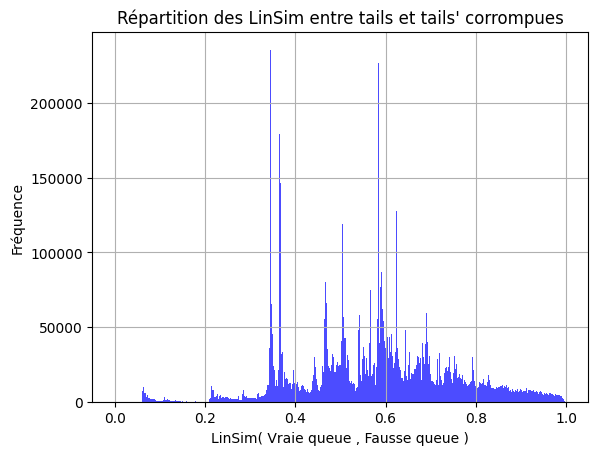

In [ ]:
df2['lin_sim'] = df2.progress_apply(lambda row: [lin_sim(nxo, idx_to_go, next(iter(row['departure'])), d) for d in iter(row['family_without_lineage'])],axis = 1)
ls = list(df2['lin_sim'])
LinSim = []
for l in ls:
    LinSim += l

tensor_array = np.array(LinSim)

# Créer un histogramme
plt.hist(tensor_array.flatten(), bins=500, color='blue', alpha=0.7)
plt.xlabel('LinSim')
plt.ylabel('Fréquence')
plt.title('Répartition des LinSim entre noeuds et famille proche (lignée exclue)')
plt.grid(True)
plt.show()

Calculating familiy - lineage: 100%|██████████| 42769/42769 [06:24<00:00, 111.27it/s]


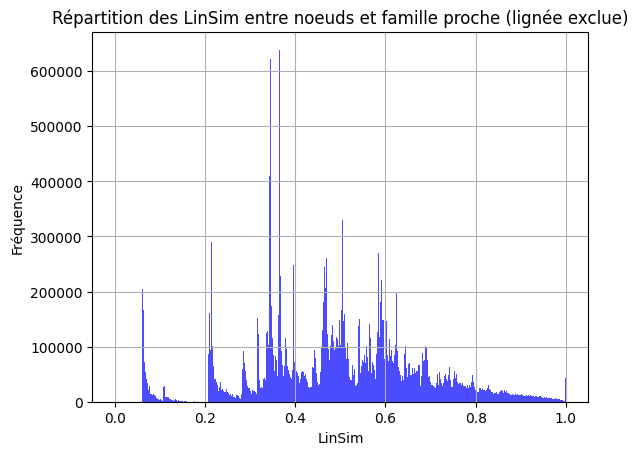

In [ ]:
df3['lin_sim'] = df3.progress_apply(lambda row: [lin_sim(nxo, idx_to_go, next(iter(row['departure'])), d) for d in iter(row['family_without_lineage'])],axis = 1)
ls = list(df3['lin_sim'])
LinSim = []
for l in ls:
    LinSim += l

tensor_array = np.array(LinSim)

# Créer un histogramme
plt.hist(tensor_array.flatten(), bins=500, color='blue', alpha=0.7)
plt.xlabel('LinSim')
plt.ylabel('Fréquence')
plt.title('Répartition des LinSim entre noeuds et famille proche (lignée exclue)')
plt.grid(True)
plt.show()

Calculating familiy - lineage: 100%|██████████| 303/303 [00:06<00:00, 44.92it/s]
/tmp/ipykernel_19502/1738360188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short4['lin_sim'] = short4.progress_apply(lambda row: [lin_sim(nxo, idx_to_go, next(iter(row['departure'])), d) for d in iter(row['family_without_lineage'])],axis = 1)


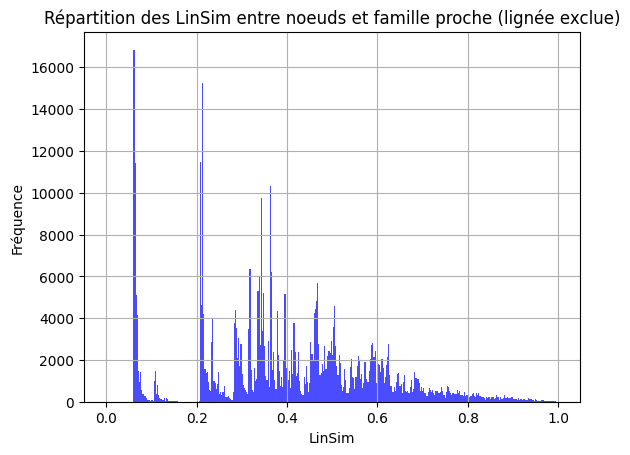

In [ ]:
short4 = df4.head(303)
short4['lin_sim'] = short4.progress_apply(lambda row: [lin_sim(nxo, idx_to_go, next(iter(row['departure'])), d) for d in iter(row['family_without_lineage'])],axis = 1)
ls = list(short4['lin_sim'])
LinSim = []
for l in ls:
    LinSim += l

tensor_array = np.array(LinSim)

# Créer un histogramme
plt.hist(tensor_array.flatten(), bins=400, color='blue', alpha=0.7)
plt.xlabel('LinSim')
plt.ylabel('Fréquence')
plt.title('Répartition des LinSim entre noeuds et famille proche (lignée exclue)')
plt.grid(True)
plt.show()

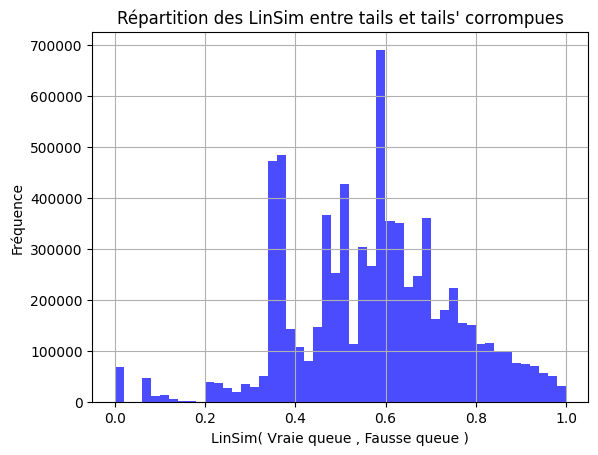

In [ ]:
tensor_array = np.array(LinSim)

plt.hist(tensor_array.flatten(), bins=50, color='blue', alpha=0.7)
plt.xlabel('LinSim( Vraie queue , Fausse queue )')
plt.ylabel('Fréquence')
plt.title('Répartition des LinSim entre tails et tails\' corrompues')
plt.grid(True)
plt.show()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
batchy = next(iter(train_loader))
print(batchy)
heads = batchy['go','is_a','go']['edge_index'][1]
print(heads)


HeteroData(
  genes={
    x=[24962, 29],
    n_id=[24962],
    num_sampled_nodes=[6],
    src_index=[1024],
  },
  go={
    x=[42976, 3],
    n_id=[42976],
    num_sampled_nodes=[6],
    dst_pos_index=[1024],
    dst_neg_index=[1024, 224],
  },
  po={
    x=[1487, 2],
    n_id=[1487],
    num_sampled_nodes=[6],
  },
  traito={
    x=[1529, 1],
    n_id=[1529],
    num_sampled_nodes=[6],
  },
  prosite_profiles={
    x=[625, 1],
    n_id=[625],
    num_sampled_nodes=[6],
  },
  prosite_patterns={
    x=[652, 1],
    n_id=[652],
    num_sampled_nodes=[6],
  },
  superfamily={
    x=[951, 1],
    n_id=[951],
    num_sampled_nodes=[6],
  },
  panther={
    x=[5509, 1],
    n_id=[5509],
    num_sampled_nodes=[6],
  },
  prints={
    x=[419, 1],
    n_id=[419],
    num_sampled_nodes=[6],
  },
  (genes, interacts_with, genes)={
    edge_index=[2, 488893],
    e_id=[488893],
    num_sampled_edges=[5],
  },
  (genes, gene_ontology, go)={
    edge_index=[2, 32453],
    edge_label=[81240],
    e_

In [ ]:
for i in range(1, 1+1):
        print(i)

1


In [ ]:
def get_direct_neighbors(ontology_edge_index, node_idx):
    parents  = ontology_edge_index[1][ontology_edge_index[0] == node_idx]
    children = ontology_edge_index[0][ontology_edge_index[1] == node_idx]
    return torch.cat([parents,children])

def get_parents(node_idx,ontology_edge_index):
    parents  = ontology_edge_index[0]
    children = ontology_edge_index[1]
    return parents[torch.where(children == node_idx)].unique()

def get_children(node_idx,ontology_edge_index):
    parents  = ontology_edge_index[0]
    children = ontology_edge_index[1]
    return children[torch.where(parents == node_idx)].unique()

def get_direct_neighbors_parents_and_children(ontology_edge_index, node_idx):
    parents  = ontology_edge_index[0]
    children = ontology_edge_index[1]
    return torch.cat([parents,children]), parents[torch.where(children == node_idx)], children[torch.where(parents == node_idx)]

node_id = 0
print(get_direct_neighbors(ontology_edge_index = GO_edge_index, node_idx=node_id))
print(get_children(         ontology_edge_index = GO_edge_index, node_idx=node_id))
print(get_parents(          ontology_edge_index = GO_edge_index, node_idx=node_id))
a = get_direct_neighbors_parents_and_children(ontology_edge_index = GO_edge_index, node_idx=node_id)


tensor([37085])
tensor([37085])
tensor([], dtype=torch.int64)


In [ ]:
print(a[1])
print(a[0])
print(a[2])
print(a[3])

tensor([ 7869, 13288, 19681, 19691, 37323])
tensor([    0,     0,     0,  ..., 29503, 29852, 32748])
tensor([ 7869, 13288, 19681, 19691, 37323])


IndexError: tuple index out of range

In [ ]:
from tqdm import tqdm

def get_n_neighborhoods(ontology_edge_index: torch.Tensor, n: int):
    
    # Listing terms
    all_terms =  torch.cat([ontology_edge_index[0], ontology_edge_index[1]]).unique()

    # Init DF
    tqdm.pandas(desc=f'Init df 1/3')

    df = pd.DataFrame(all_terms.tolist(), columns=['0-neighbors'])
    df['0-neighbors'] = df.progress_apply(lambda row : torch.tensor(row['0-neighbors']),
                                         axis=1,)
    tqdm.pandas(desc=f'Init df 2/3')
    df['0-children'] = df.progress_apply(lambda row : get_children(node_idx=row['0-neighbors'], ontology_edge_index=ontology_edge_index),
                                         axis=1,)
    tqdm.pandas(desc=f'Init df 3/3')
    df['0-parents']  = df.progress_apply(lambda row : get_parents(node_idx=row['0-neighbors'], ontology_edge_index=ontology_edge_index),
                                         axis=1,)

    # Iterate to build n-neighborhood
    for dist in range(1, n+1) :        
        

        tqdm.pandas(desc=f'Calculating children at distance {dist}/{n}')
        df[f'{dist}-children'] = df.progress_apply(lambda row : get_children(node_idx=row['0-neighbors'], ontology_edge_index=ontology_edge_index),
                                            axis=1,)
        tqdm.pandas(desc=f'Calculating parents at distance {dist}/{n}')
        df[f'{dist}-parents']  = df.progress_apply(lambda row : get_parents(node_idx=row['0-neighbors'], ontology_edge_index=ontology_edge_index),
                                            axis=1,)
        
        
        # tqdm.pandas(desc=f'Calculating children at distance {dist}/{n}')
        # df[f'{dist}-children'] = df.progress_apply(lambda row : get_children(node_idx=row[f'{dist-1}-neighbors'],
        #                                                                            ontology_edge_index=GO_edge_index).tolist(),
        #                             axis=1,
        #                             )
        
        # tqdm.pandas(desc=f'Calculating parents at distance {dist}/{n}')
        # df[f'{dist}-parents']  = df.progress_apply(lambda row : get_parents(node_idx=row[f'{dist-1}-neighbors'],
        #                                                                            ontology_edge_index=GO_edge_index).tolist(),
        #                             axis=1,
        #                             )
        
    return df

init = get_n_neighborhoods(ontology_edge_index=GO_edge_index, n=1)
# neighbourhood = get_n_neighborhoods(ontology_edge_index=GO_edge_index, n=2)
# display(neighbourhood)
display(init)


Calculating parents at distance 1/1: 100%|██████████| 42769/42769 [00:07<00:00, 6079.12it/s]


,0-neighbors,0-children,0-parents,1-children,1-parents
0,tensor(0),[tensor(37085)],[],[tensor(37085)],[]
1,tensor(1),[tensor(25649)],[],[tensor(25649)],[]
2,tensor(2),[tensor(23738)],[],[tensor(23738)],[]
3,tensor(3),"[tensor(17678), tensor(25936)]",[],"[tensor(17678), tensor(25936)]",[]
4,tensor(4),"[tensor(302), tensor(12265), tensor(23167), te...",[],"[tensor(302), tensor(12265), tensor(23167), te...",[]
...,...,...,...,...,...
42764,tensor(42974),[tensor(4542)],"[tensor(12337), tensor(25250), tensor(38537)]",[tensor(4542)],"[tensor(12337), tensor(25250), tensor(38537)]"
42765,tensor(42975),"[tensor(384), tensor(34451), tensor(35697)]",[],"[tensor(384), tensor(34451), tensor(35697)]",[]
42766,tensor(42976),[tensor(34078)],[],[tensor(34078)],[]
42767,tensor(42977),[tensor(20480)],[],[tensor(20480)],[]


In [ ]:
print(init.columns[0])
print(init.columns[0] == '0-neighbors')

0-neighbors
True


In [ ]:
n = 1
df = init
for dist in range(1, n+1) :        
        
    tqdm.pandas(desc=f'Calculating parents at distance {dist}/{n}')
    # df[f'{dist}-parents'] 
    a = df.progress_apply(lambda row : get_parents(node_idx=row[f'{dist-1}-neighbors'],
                                                                                   ontology_edge_index=GO_edge_index).tolist(),
                                    axis=1,
                                    )
    

Calculating children at distance 1/1: 100%|██████████| 42769/42769 [00:07<00:00, 5400.53it/s]


In [ ]:
print(type(a))
print(len(a))
display(a)

<class 'pandas.core.series.Series'>
42769


0                           [37085]
1                           [25649]
2                           [23738]
3                    [17678, 25936]
4        [12265, 302, 23167, 38597]
                    ...            
42764                        [4542]
42765           [384, 35697, 34451]
42766                       [34078]
42767                       [20480]
42768                       [13141]
Length: 42769, dtype: object